In [5]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [6]:
pip install scikit-image


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
seed = 42
np.random.seed = seed


In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [9]:
TRAIN_IMAGE_PATH = 'Wound_Dataset/train/images/'
TRAIN_LABEL_PATH = 'Wound_Dataset/train/labels/'

In [10]:
train_ids = next(os.walk(TRAIN_IMAGE_PATH))[2]

In [11]:
print(train_ids)

['0020126b06a719c36fed196c2c71f2f0_0.png', '002985bcbd572241a950bf39b4188d70_0.png', '00437234527092743faeb39bc59bd7ee_0.png', '00be2ad4736f6657b767683186615f3f_0.png', '00bf40d77104c2b4d6d55e431ca009b9_0.png', '00d87e85e220404257d75a9c6d574e0b_0.png', '01289b5d0d3f47b0de56c003ec81614a_0.png', '01289b5d0d3f47b0de56c003ec81614a_1.png', '026d4acc83cb338c02ade317e0816f61_0.png', '0272003ec882522e7bec012aac93cc26_0.png', '0272003ec882522e7bec012aac93cc26_1.png', '0272003ec882522e7bec012aac93cc26_2.png', '0272003ec882522e7bec012aac93cc26_3.png', '02858ff80779671801b922af42c72df6_0.png', '0301eae58a63514483f1f05436437ac2_0.png', '0301eae58a63514483f1f05436437ac2_1.png', '030f458bd12ad589f1c2d6ae4cc245e0_0.png', '035b9aff921b413432a9b2b6d68e4c50_1.png', '035b9aff921b413432a9b2b6d68e4c50_2.png', '03722f11a500f35511add8b2ecf54e61_0.png', '03a29338d44c41efd1856034029cb9cb_0.png', '03a29338d44c41efd1856034029cb9cb_1.png', '03a29338d44c41efd1856034029cb9cb_2.png', '03b7f4b22ab4357bbf58da1540daf836

In [12]:
# Initialize arrays to store images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [13]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    
    image_path = os.path.join(TRAIN_IMAGE_PATH, id_)
    img = imread(image_path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img


    mask_path = os.path.join(TRAIN_LABEL_PATH, id_)
    mask = imread(mask_path)
    mask = np.sum(mask, axis=-1, keepdims=True)  
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = mask.astype(bool)  
    Y_train[n] = mask 


Resizing training images and masks


  0%|▎                                                                                 | 3/831 [00:00<00:34, 23.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 831/831 [00:19<00:00, 41.68it/s]


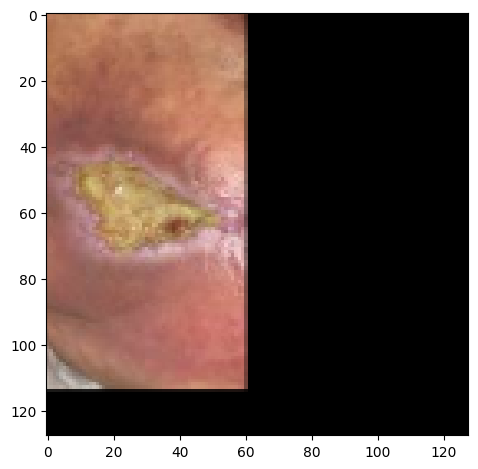

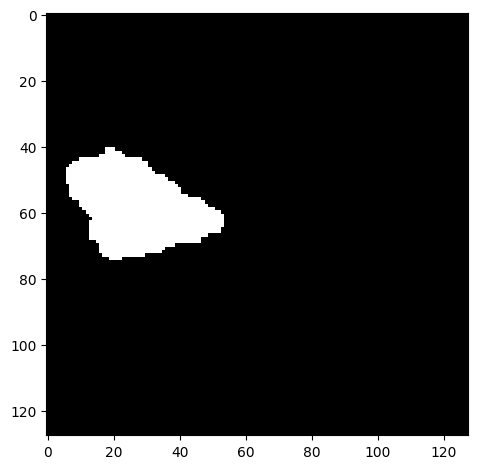

In [21]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()


In [22]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [23]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [25]:
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [26]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [27]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

 dropout_9 (Dropout)         (None, 16, 16, 128)          0         ['conv2d_18[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)          (None, 16, 16, 128)          147584    ['dropout_9[0][0]']           
                                                                                                  
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 64)           32832     ['conv2d_19[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_5 (Concatenate  (None, 32, 32, 128)          0         ['conv2d_transpose_5[0][0]',  
 )                                                                   'conv2d_5[0][0]']            
                                                                                                  
 conv2d_20

In [28]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('woundSegmentation_model.h5', verbose=1, save_best_only=True)

In [29]:

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        checkpointer,
]

In [30]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
42/42 [==============================] - ETA: 0s - loss: 0.2654 - accuracy: 0.9427
Epoch 1: val_loss improved from inf to 0.08832, saving model to woundSegmentation_model.h5


C:\Users\Muthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 149s 3s/step - loss: 0.2654 - accuracy: 0.9427 - val_loss: 0.0883 - val_accuracy: 0.9640
Epoch 2/25
42/42 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9639
Epoch 2: val_loss improved from 0.08832 to 0.07863, saving model to woundSegmentation_model.h5
42/42 [==============================] - 128s 3s/step - loss: 0.0800 - accuracy: 0.9639 - val_loss: 0.0786 - val_accuracy: 0.9641
Epoch 3/25
42/42 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9675
Epoch 3: val_loss improved from 0.07863 to 0.07041, saving model to woundSegmentation_model.h5
42/42 [==============================] - 119s 3s/step - loss: 0.0722 - accuracy: 0.9675 - val_loss: 0.0704 - val_accuracy: 0.9727
Epoch 4/25
42/42 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9749
Epoch 4: val_loss improved from 0.07041 to 0.05662, saving model to woundSegmentation_model.h5
42/42 [==============================] - 11

In [2]:
from keras.models import load_model
model = load_model('woundSegmentation_model.h5')
#predictions = model.predict(X_test)


In [3]:
TEST_IMAGE_PATH = 'Wound_Dataset/test/images/'
TEST_LABEL_PATH = 'Wound_Dataset/test/labels/'

In [6]:
test_ids = next(os.walk(TEST_IMAGE_PATH))[2]

In [7]:
print(test_ids)

['b23232898bafcf304b2138af86be40b9_0.png', 'b586407933e66b112820f28448783627_0.png', 'b61269467f2dc93f3cc31f933fa7013a_0.png', 'b712446cdd649dcb735673f7322daa69_0.png', 'b99276bf857375e23da3a9f5388cd6ce_0.png', 'ba00cb9444f74badd3afada2bd3d6642_0.png', 'ba4755da013537410deae3f8386d08ba_0.png', 'ba4755da013537410deae3f8386d08ba_1.png', 'baba5451a41a555f6ea4355b4c53db59_0.png', 'baba5451a41a555f6ea4355b4c53db59_1.png', 'baf6df704ae535e46fe2f366a58f219c_0.png', 'baf6df704ae535e46fe2f366a58f219c_1.png', 'baf6df704ae535e46fe2f366a58f219c_2.png', 'baf6df704ae535e46fe2f366a58f219c_3.png', 'bb267b1abca1c53df371bc15bf592070_0.png', 'bb59a635e988cbe2323c92ff2bb04e91_0.png', 'bb7f8181ab26743700a45af24d7bc47b_0.png', 'bb7f8181ab26743700a45af24d7bc47b_1.png', 'bbcede236aef5e690eb18bb7cc585c69_0.png', 'bbf82a8180020c2a8b38e6f8c7c86d7d_0.png', 'bbfe627c5a6d2322d419a10720b9219c_0.png', 'bc29987427c1c3995fd2109e730a4336_0.png', 'bc6afdb212331d00685eae069e455957_0.png', 'bdbab63e08219299b187e057d9a7b783

In [11]:
# Initialize arrays to store images and masks
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [13]:
print('Resizing testing images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    # Read and resize image
    image_path = os.path.join(TEST_IMAGE_PATH, id_)
    img = imread(image_path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img  # Fill empty X_train with values from img

    # Read and resize mask
    mask_path = os.path.join(TEST_LABEL_PATH, id_)
    mask = imread(mask_path)
    mask = np.sum(mask, axis=-1, keepdims=True)  # Collapse channels by summing
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = mask.astype(bool)  # Convert mask to boolean values
    Y_test[n] = mask  # Remove extra dimensions


Resizing testing images and masks


  0%|                                                                                                                              | 0/278 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:08<00:00, 31.24it/s]


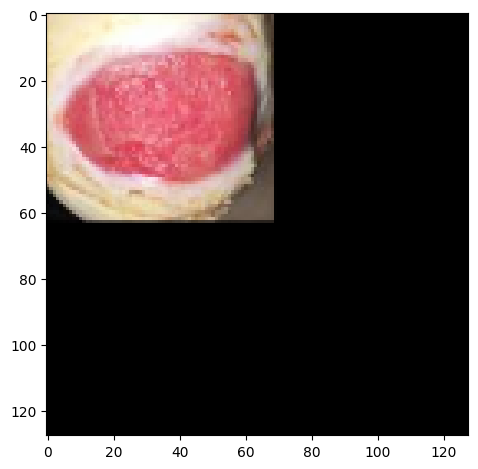

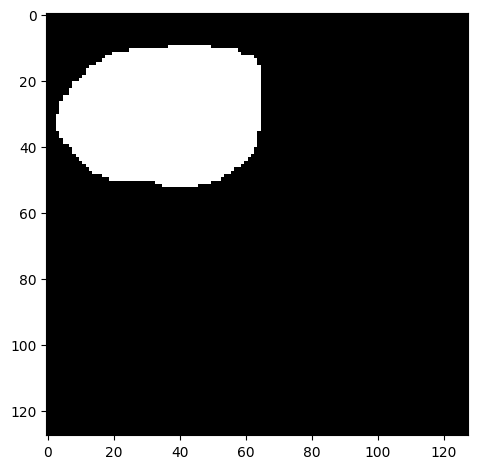

In [14]:
image_x = random.randint(0, len(test_ids))
imshow(X_test[image_x])
plt.show()
imshow(np.squeeze(Y_test[image_x]))
plt.show()


In [15]:
preds_test = model.predict(X_test, verbose=1)

9/9 [==============================] - 7s 710ms/step


In [16]:
print(preds_test)

[[[[7.9676388e-03]
   [4.1630897e-03]
   [2.3149711e-03]
   ...
   [3.9617502e-04]
   [6.3892739e-04]
   [1.3862384e-02]]

  [[2.3177864e-03]
   [1.2464195e-03]
   [7.7540876e-04]
   ...
   [1.4524144e-05]
   [5.6666879e-05]
   [2.8388440e-03]]

  [[1.0606864e-03]
   [9.7428286e-04]
   [7.3865795e-04]
   ...
   [3.3897004e-06]
   [9.6668191e-06]
   [3.0819203e-03]]

  ...

  [[1.8358085e-03]
   [6.6035587e-05]
   [2.0213083e-05]
   ...
   [7.1546546e-09]
   [2.5910364e-07]
   [3.1478022e-04]]

  [[2.2384184e-03]
   [5.2547012e-04]
   [1.2840894e-04]
   ...
   [1.2951944e-06]
   [8.0717373e-06]
   [3.0626059e-03]]

  [[2.1208279e-02]
   [5.2246046e-03]
   [3.4017072e-03]
   ...
   [1.4241610e-04]
   [5.0914561e-04]
   [1.3196430e-02]]]


 [[[2.9202575e-02]
   [2.5055217e-02]
   [1.7899448e-02]
   ...
   [4.1700539e-04]
   [6.7627290e-04]
   [1.4323695e-02]]

  [[1.1151799e-02]
   [9.3810707e-03]
   [9.8440638e-03]
   ...
   [1.5451966e-05]
   [6.0089642e-05]
   [2.9544074e-03]]

  [[7.2

In [17]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [18]:
print(preds_test_t)

[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]

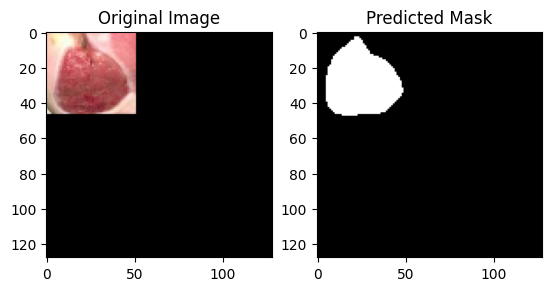

In [328]:
import matplotlib.pyplot as plt

# Assuming preds_test_t contains the binary predictions for the test data

# Choose a sample index to visualize
sample_index = random.randint(0,len(X_test))

# Display original test image
plt.subplot(1, 2, 1)
plt.imshow(X_test[sample_index])
plt.title('Original Image')

# Display predicted mask
plt.subplot(1, 2, 2)
plt.imshow(preds_test_t[sample_index].squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
plt.title('Predicted Mask')

plt.show()


In [321]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(preds_test_t.flatten(),Y_test.flatten())

0.9871016028973696

In [21]:
confusion_matrix(preds_test_t.flatten(),Y_test.flatten())

array([[4365892,   37811],
       [  20938,  130111]], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming preds_test_t contains the binary predictions for the test data
# And y_true contains the ground truth labels for the test data

# Flatten the predictions and ground truth labels
preds_flat = preds_test_t.flatten()
y_true_flat = Y_test.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_true_flat, preds_flat)

# Calculate precision
precision = precision_score(y_true_flat, preds_flat)

# Calculate recall
recall = recall_score(y_true_flat, preds_flat)

# Calculate F1 score
f1 = f1_score(y_true_flat, preds_flat)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9871016028973696
Precision: 0.8613827301074486
Recall: 0.7748299805862245
F1 Score: 0.8158171119004548


In [3]:
var = random.randint(0,len(X_test)-1)
plt.imshow((X_test[var]*preds_test_t[var]).squeeze())

NameError: name 'random' is not defined

In [4]:
import matplotlib.pyplot as plt

# Assuming X_test[var] and woundIsolation are your images
woundIsolation = preds_test_t[var];
woundColorIsolation=X_test[var]*preds_test_t[var]
# Create a new figure
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)
plt.imshow(X_test[var].squeeze(), cmap='gray')  # Assuming X_test[var] is grayscale
plt.title('Original Image')
plt.axis('off')

# Plot the second image (woundIsolation overlay)
plt.subplot(1, 3, 2)
plt.imshow(woundIsolation.squeeze(), cmap='gray')  # Assuming woundIsolation is grayscale
plt.title('Wound Isolation Overlay')
plt.axis('off')

# Plot the third image (woundColorIsolation overlay)
plt.subplot(1, 3, 3)
plt.imshow(woundColorIsolation.squeeze(), cmap='gray')  # Assuming woundColorIsolation is grayscale
plt.title('Wound Color Isolation Overlay')
plt.axis('off')

# Adjust layout
plt.tight_layout()



# Show the plot
plt.show()


NameError: name 'preds_test_t' is not defined

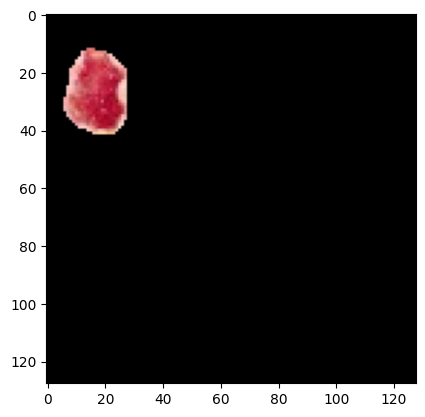

In [203]:
plt.imshow(woundColorIsolation.squeeze())

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming woundIsolation is your array with shape (128, 128, 1)
# Assuming woundColorIsolation is your array with shape (128, 128, 3)

# Scale values from range [0, 1] to [0, 255]
woundIsolation = (woundIsolation * 255).astype(np.uint8)
woundColorIsolation = np.clip(woundColorIsolation, 0, 255).astype(np.uint8)
# Clip to ensure values are in [0, 255]

# Convert to PIL Image
Maskedimage = Image.fromarray(woundIsolation.squeeze())  # mode='L' for grayscale
Maskedimage_color = Image.fromarray(woundColorIsolation)  # Assuming woundColorIsolation is in RGB format

# Save the images
Maskedimage.save("Masked_output_image.png")
Maskedimage_color.save("Masked_color_output_image.png")

# Display the images
plt.imshow(Maskedimage)
plt.axis('off')
plt.show()

plt.imshow(Maskedimage_color)
plt.axis('off')
plt.show()


NameError: name 'woundIsolation' is not defined

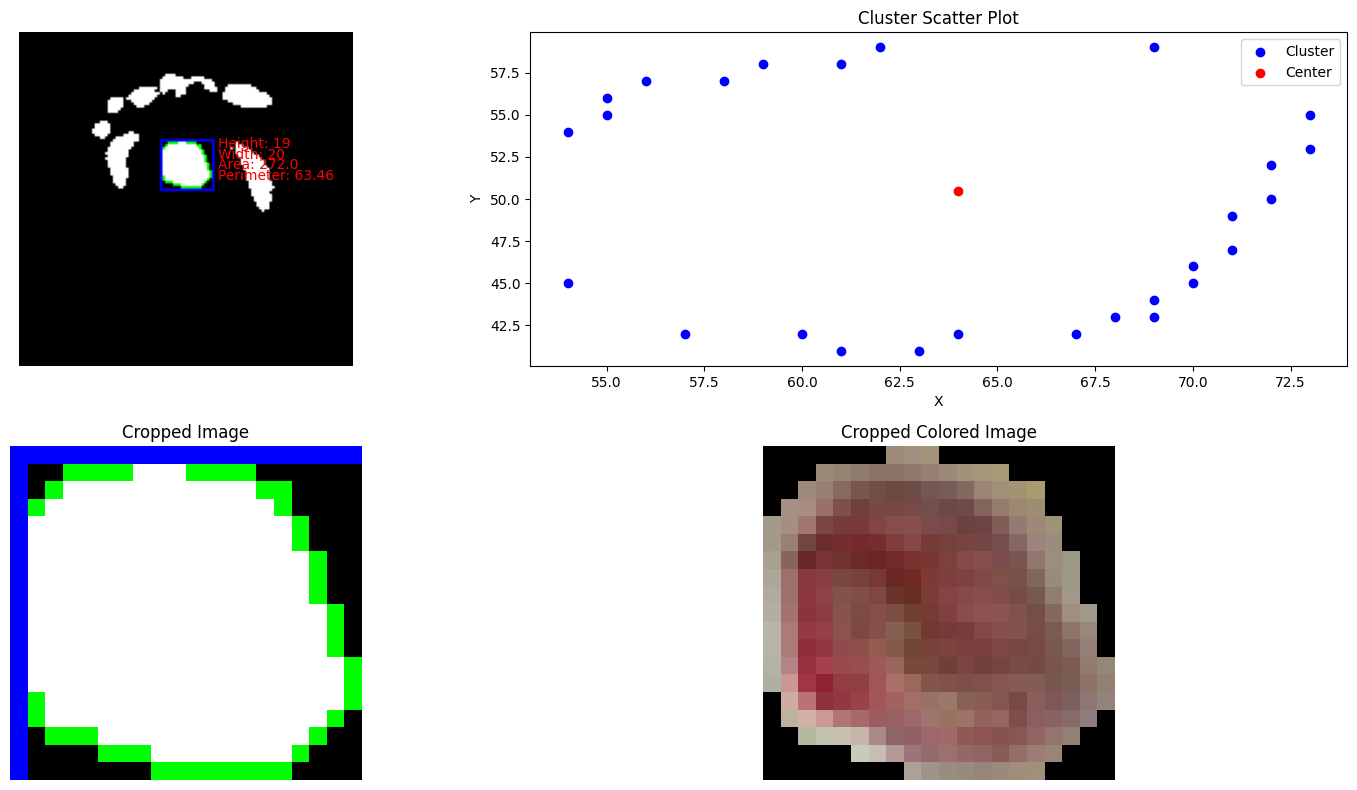

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
Maskedimage = cv2.imread("MaskedTest_output_image.png")
Maskedimage_color = cv2.imread("MaskedTest_color_output_image.png")

gray = cv2.cvtColor(Maskedimage, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
area = cv2.contourArea(largest_contour)
perimeter = cv2.arcLength(largest_contour, True)
x, y, w, h = cv2.boundingRect(largest_contour)
cv2.drawContours(Maskedimage, [largest_contour], -1, (0, 255, 0), 1)
cv2.rectangle(Maskedimage, (x, y), (x + w, y + h), (255, 0, 0), 1)

# Create a figure with subplots
plt.figure(figsize=(16, 8))

# Display the original image with properties
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(Maskedimage, cv2.COLOR_BGR2RGB))

plt.axis('off')
plt.text(x + w + 2, y + 3, f'Height: {h}', color='red', fontsize=10)
plt.text(x + w + 2, y + 7, f'Width: {w}', color='red', fontsize=10)
plt.text(x + w + 2, y + 11, f'Area: {area}', color='red', fontsize=10)
plt.text(x + w + 2, y + 15, f'Perimeter: {perimeter:.2f}', color='red', fontsize=10)
plt.savefig("pr_image.png", bbox_inches='tight', pad_inches=0)

# Plot the scatter plot of the largest contour
plt.subplot(2, 2, 2)
plt.scatter(largest_contour[:, 0, 0], largest_contour[:, 0, 1], color='blue', label='Cluster')
plt.scatter(x + w / 2, y + h / 2, color='red', label='Center')
plt.title('Cluster Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

cropped_image = Maskedimage[y:y+h, x:x+w]
cropped_color_image = Maskedimage_color[y:y+h, x:x+w]

# Display the cropped masked image
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image')
plt.axis('off')

# Display the cropped colored image
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(cropped_color_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Colored Image')
plt.axis('off')

plt.tight_layout()
plt.show()
